# Minecraft DSCI100 Group Project

## Introduction ##

The following datasets were taken from the research group The Pacific Laboratory for Artificial Intelligence (PLAI). They collected behavioural data on their MineCraft server, PlaiCraft. This was done by recording the gameplay, speech, and key presses in the PLAICraft Minecraft browser window. This project aims to collect data to develop a complex embodied AI, which can act, think, and learn in a virtual environment such as MineCraft. 

The question that this project aims to answer is:
**“From the `players.csv` dataset, can a player’s age and playtime hours predict whether they will subscribe to a game-related newsletter?”**/

## Description of Data Sets ##

### Collection of Data ###
- Player information collected through self-reporting
- Unique hashedEmail assigned randomly for identification
- Played_hours obtained by recording the player's total playtime


### `players.csv` ###
This data set has 196 observations with 7 variables

|Variable | Type | Meaning | Summary Statistics | 
|---------|--|---------| -------------------- |
|experience | character | Self-reported experience level of the player | Amateur: 63 , Beginner: 35, Pro: 14, Regular: 36, Veteran: 48 | 
| subscribe | logical | Whether the player is subscribed to game-related newsletter or not | FALSE: 52, TRUE: 144 | 
| hashedEmail | character | Encoded email addresses of players to maintain privacy | Not Applicable | 
|played_hours | double | Total hours of Minecraft played on PLAICraft| Min: 0, Max: 223.1, Mean: 5.85, Median: 0.1| 
|name | character | Name of player | Not Applicable |
|gender | character | Gender of the player | Agender: 2, Male: 124, Female: 37, Non-Binary: 15, Other: 1, Prefer not to say: 11, Two-Spirited: 6
|Age | double | Age of the player in years | Min: 0, Max: 58, Mean: 21.13, Median: 19 | 

#### Figure 1. Description of `players.csv` dataset ####

### `sessions.csv` ###
This data set has 1535 observations with 5 variables
| Variable | Type | Meaning | 
|------|------- |-----------|
| hashedEmail | character | Player's encoded email addresses to maintain privacy | 
| start_time | character | Start time of gameplay session | 
| end_time | character | End time of gameplay session | 
| original_start_time | double | Start time in Unix time |
| original_end_time| double | End time in Unix time |

#### Figure 2. Description of `sessions.csv` dataset

### Potential Issues ###
- In `players.csv`, the column names are not standardized. Age is capitalized, while the other variable names are not
- In `players.csv`, experience is self-reported, which might be an inaccurate representation of actual skill

## Question ##
The broad question we aim to address is:

**“Can player characteristics be used to predict behavioural outcomes in the dataset?”**

The specific question we focus on is:

**“From the `players.csv` dataset, can a player’s age and playtime hours predict whether they will subscribe to a game-related newsletter?”**

To answer this question, we will build a k-nearest neighbours (k-NN) classification model, where:

Response variable:
- subscribe (yes/no)

Explanatory variables:
- age (numeric)
- playtime_hours (numeric)

The `players.csv` dataset contains all three of these variables, which allows us to construct a predictive model. Because the k-NN algorithm requires numerical predictors, we selected age and playtime hours as they are both quantitative and suitable for calculating distance.

# Methods and Results

This project can be split up into 3 subsections:

### Initial data processing
- Import libraries and load `players.csv` dataset from the URL.
- Clean and wrangle data to the necessary format for analysis.
- Split the data into training and testing sets.
- Create summary statistics for the training set to make predictions about the classifier.
- Visualize the relationship between players' age and played hours to understand data distribution.
- Create a recipe for preprocessing (normalising predictors for k-NN)
- Define an initial k-NN model with neighbors = tune() to allow k to be selected.
- Use cross-validation and a tuning grid to test multiple k values and identify the best-performing k.
  
### Visualization
- To visualize our results, we plotted age on the x-axis and played_hours on the y-axis, using subscribe to colour the points.
- To check for over/underfitting, we coloured the background of the graph based on what prediction would be made at every possible point, allowing quick identification of how the model classified players, and where the boundaries were.
  
### Classifier evaluation
- made a new model specification for the best k value chosen, combined it with the recipe, and fitted the classifier to the training set.
- predicted on the testing set to test the classifier's accuracy on unseen data.
- created a confusion matrix to establish which predictions were the most accurate and the consequential effects on real-world application.

## Initial Setup (importing necessary libraries)

In [2]:
# Importing libraries
library(repr)
library(tidyverse)
library(tidymodels)
library(dplyr)
library(RColorBrewer)
options(repr.matrix.max.rows = 10)
set.seed(1234)

options(repr.plot.width = 12, repr.plot.height = 6)

## Reading in the Data

To answer our question, we will only be using the `players.csv` dataset. It can be loaded into R using the following line of code. The column name Age was changed to age:

In [3]:
players_data <- read_csv("https://raw.githubusercontent.com/sophiaymeng/dsci_100_008_7_minecraft/refs/heads/main/data/players%20(1).csv", show_col_types = FALSE)|>
    rename(age = Age) 
head(players_data)

experience subscribe
1 Pro         TRUE    
2 Veteran     TRUE    
3 Veteran    FALSE    
4 Amateur     TRUE    
5 Regular     TRUE    
6 Amateur     TRUE    
  hashedEmail                                                      played_hours
1 f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d 30.3        
2 f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9  3.8        
3 b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28  0.0        
4 23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5  0.7        
5 7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e  0.1        
6 f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977  0.0        
  name      gender age
1 Morgan    Male    9 
2 Christian Male   17 
3 Blake     Male   17 
4 Flora     Female 21 
5 Kylie     Male   21 
6 Adrian    Female 17

#### Figure 3: `players.csv` dataset before wrangling

## Wrangling and Cleaning the Data
Next, we minimally wrangeld the data so that rows containing NA were removed.

In [4]:
players_data <- players_data |>
    mutate(experience = as_factor(experience),
           subscribe = as_factor(subscribe),
           name = as_factor(name), 
           gender = as_factor(gender), 
           hashedEmail = as_factor(hashedEmail)) |>
    drop_na(age)
head(players_data)

experience subscribe
1 Pro        TRUE     
2 Veteran    TRUE     
3 Veteran    FALSE    
4 Amateur    TRUE     
5 Regular    TRUE     
6 Amateur    TRUE     
  hashedEmail                                                      played_hours
1 f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d 30.3        
2 f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9  3.8        
3 b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28  0.0        
4 23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5  0.7        
5 7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e  0.1        
6 f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977  0.0        
  name      gender age
1 Morgan    Male    9 
2 Christian Male   17 
3 Blake     Male   17 
4 Flora     Female 21 
5 Kylie     Male   21 
6 Adrian    Female 17

#### Figure 4. Tidy `players.csv` dataset

## Splitting the Data into Training and Testing Sets

To make predictions with our data, we need to first split it into training and testing sets. We chose to split the data with 75% of the data in the training set and 25% in the testing set. This ratio allows us to train the model with as many data points as possible, while still having a sufficient amount of data to test the model.

We used initial_split to shuffle the data before splitting, ensuring that ordering of the data set does not affect the split. Additionally, we also stratify it by subscription to ensure approximately equal proportions per class in each set.

Finally, we set a random seed  to ensure reproducibility.

In [6]:
set.seed(1234)

players_split <- players_data |>
    initial_split(prop = 0.75, strata = subscribe)

players_training <- training(players_split)
players_testing <- testing(players_split)

head(players_training)

nrow(players_training)
nrow(players_testing)

experience subscribe
1 Amateur    FALSE    
2 Amateur    FALSE    
3 Amateur    FALSE    
4 Veteran    FALSE    
5 Veteran    FALSE    
6 Veteran    FALSE    
  hashedEmail                                                      played_hours
1 1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd 0.0         
2 2313a06afe47eacc28ff55adf6f072e7d12b0d12d7cbae29656f9029ec72bb53 0.0         
3 200db0417ee70863c7e2a0f214c737476fb86de5869d0b907a077d726357e687 0.1         
4 f8acd26a5e452b682b9f8b20108caef1ee2e745efe08e95806980bd2388a3fea 0.0         
5 951e54f7376e2b2f0915e9e3646c701af4a2fe839385b13f9e0084b08f8070bd 0.1         
6 88247d9a46fc214a12485dcbcbb03a8ddebfe8c1ec5fe209cd660147625c8e62 1.4         
  name      gender            age
1 Emerson   Male              21 
2 Quinlan   Male              22 
3 Anastasia Female            17 
4 Finn      Male              23 
5 Vivienne  Male              18 
6 Aiden     Prefer not to say 25

[1] 145

[1] 49

#### Figure 5. Splitting the data into training and testing sets

## Summarizing the Data

Before we create our prediction model, we calculated a summary of statistics regarding the relavant variables below.

In [7]:
players_summary <- players_data |>
                    group_by(subscribe) |>
                    summarize(mean_age = mean(age), 
                              min_age = min(age),
                              max_age = max(age),
                              mean_played_hours = mean(played_hours),
                              min_played_hours = min(played_hours),
                              max_played_hours = max(played_hours),
                              n_of_players = n())

players_summary

subscribe mean_age min_age max_age mean_played_hours min_played_hours
1 FALSE     23.7500  17      57      0.5019231         0               
2 TRUE      20.1831   9      58      7.8830986         0               
  max_played_hours n_of_players
1   7.1             52         
2 223.1            142

#### Figure 6. Summary of the mean, median, min, max, and ount of players in dataset

## Preliminary Data Visualization

To visualize the relationship that age and played hours have with a player's subscription status, we will use ggplot to generate a scatter plot of age vs played_hours, colouring the points based on the subscribe variable.



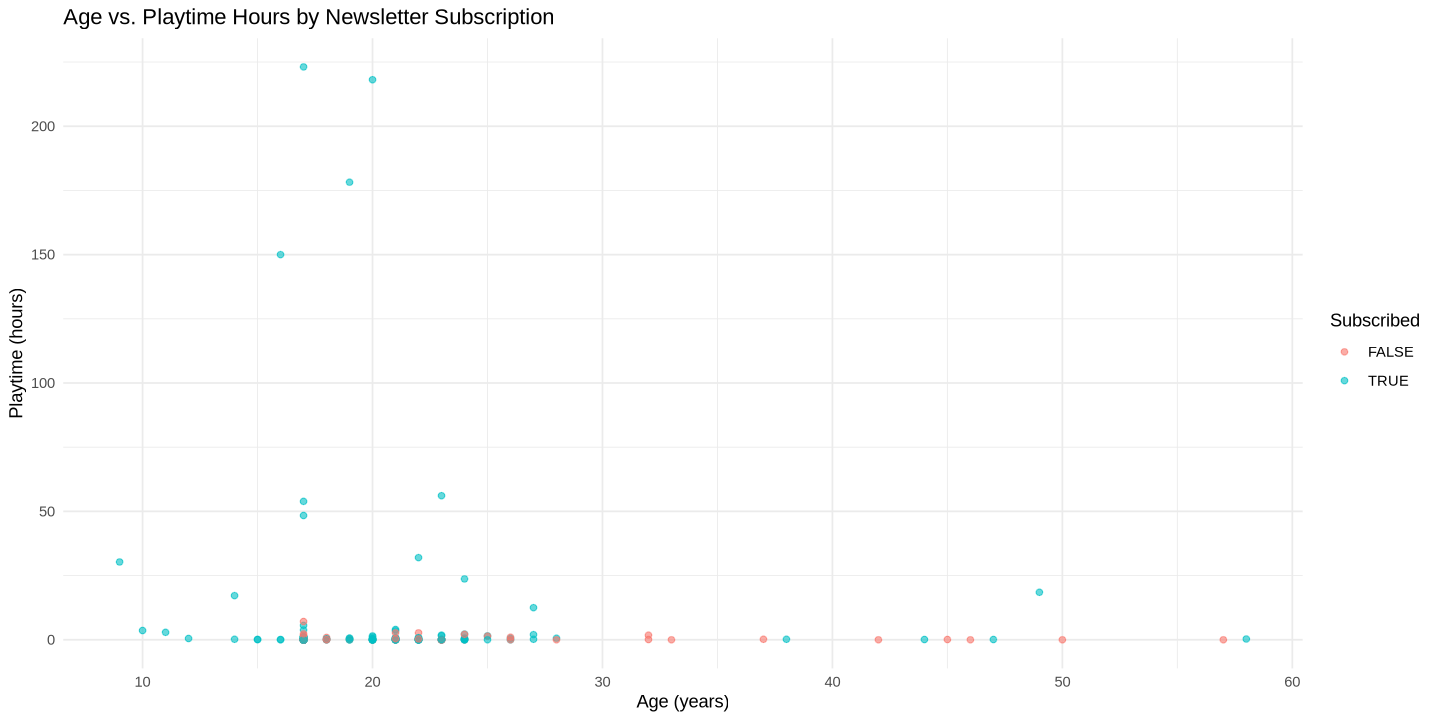

In [8]:
ggplot(players_data, aes(x = age, y = played_hours, color = subscribe)) +
  geom_point(alpha = 0.6) +
  labs(title = "Age vs. Playtime Hours by Newsletter Subscription",
       x = "Age (years)",
       y = "Playtime (hours)",
       color = "Subscribed") +
  theme_minimal()
     

#### Figure 7: Scatterplot of Playtime (hours) as a function of Age (years)

This graph shows that unsubscribed players (red) tend to be older and play less, while subscribed players (teal) have a wider spread of age and playtime, with a tendency for longer playtime and younger. This plot shows that there is probably a relationship between these variables, which can be defined using predictive modelling.

## Finding the Best K-value

### Pipeline
1. #### Preprocess the data
   Create a recipe using players_training that predicts experience from the predictors age and played_hours.
2. #### Set up the KNN model for tuning
   Define a KNN classification model with neighbors = tune().
3. #### Perform cross-validation
   Use 10-fold cross-validation with
   vfold_cv(players_training, v = 10, strata = experience)
   Stratifying by experience preserves class proportions across folds, and using multiple folds reduces sensitivity to how the    validation set is split.
4. #### Build a workflow for tuning
   Combine the recipe and the model into a workflow.
5. #### Create a Grid and Choose Best K
   Define a grid where 1 ≤ k ≤ 50 and evaluate each value across all validation folds.
   Create a line plot to determine the best K with:\
   x-axis: number of neighbors\
   y-axis: accuracy estimate

   The resulting line plot shows where accuracy peaks and helps identify the best k.
7. #### Check for Underfitting and Overfitting
   Ensure lack of underfitting and overfitting so there is more accuracy than a majority classifier, using our new k.


To ensure reproducibility, we will use set.seed(1234) throughout this report.

In [7]:
set.seed(1234)

# Standardization recipe
players_recipe <- recipe(subscribe ~ age + played_hours, data = players_training) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

# KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

# 10 fold-cross valdiation
players_vfold <- vfold_cv(players_training, v = 10, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 2))

# Create workflow
knn_results <- workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_spec) |>
      tune_grid(resamples = players_vfold, grid = k_vals) |>
      collect_metrics() 

accuracies <- knn_results |>
      filter(.metric == "accuracy") 

best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        select(neighbors, mean)
best_k

neighbors mean     
1 21        0.7532601

#### Figure 8: Best K-value after 10 fold-cross validation

We can also confirm our findings by plotting the accuracies dataset graphically:

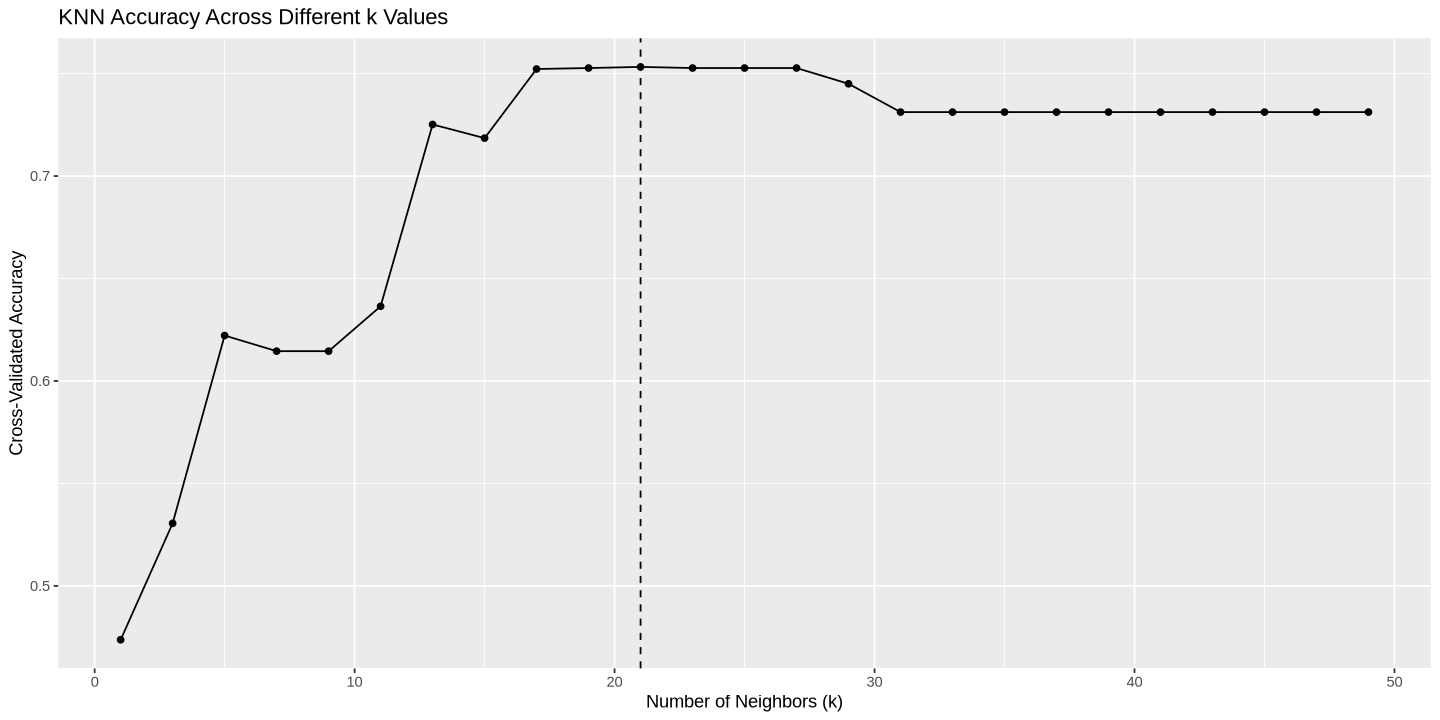

In [8]:
ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_line() +
  geom_point() +
  geom_vline(
    xintercept = best_k$neighbors,
    linetype = "dashed"
  ) +
  labs(
    title = "KNN Accuracy Across Different k Values",
    x = "Number of Neighbors (k)",
    y = "Cross-Validated Accuracy"
  )

#### Figure 9: Accuracy vs K-values

In this line-plot, we can see how accuracy fluctuates as we change the number of neighbours. This graph shows the accuract begins to level off at around k = 21. Choosing any neighbours less than 21 would sacrifice accuracy/underfitting, while choosing a k greater than 21 would be more likely to cause overfitting. 

### Comparing to a majority classifier

Using group_by and summarize on the subscribe variable shows up the proportion of people subcribed (TRUE) vs not subscibed (FALSE).

In [9]:
#Comparing accuracy of classifier with majority classifier
players_proportions <- players_training |>
    group_by(subscribe) |>
    summarize(
        count = n(),
        percentage = n() / nrow(players_training) * 100
      )
players_proportions

subscribe count percentage
1 FALSE      39   26.89655  
2 TRUE      106   73.10345

#### Figure 10: Comparing Accuracy

Thus, a TRUE subscription status is the majority of the training data (73.10% of all results), and we will consider how this imbalance affects our classifier prediction below.


## Building our Final Model

With k found, we can create our final spec with neighbors = 19. We then fit it to players_training.

In [10]:
set.seed(1234)

# Final model specification using selected k (21)
final_spec <- nearest_neighbor(weight_func="rectangular", neighbors = 21) |>
    set_engine("kknn") |>
    set_mode("classification")

# Final workflow
final_workflow <- workflow() |>
    add_recipe(players_recipe)|>
    add_model(final_spec) |>
    fit(data = players_training)

final_workflow

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(21,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2482759
Best kernel: rectangular
Best k: 21

Now that we have our final model, we can evaulate it on unseen data (our testing set) to evaluate its accuracy:

In [11]:
set.seed(1234)

# Predict
player_test_predictions <- final_workflow |>
    predict(players_testing) |>
    bind_cols(players_testing)

# Prediction accuracy
player_test_accuracy <- player_test_predictions |> 
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy") 
player_test_accuracy
    
# Confusion matrix to find weak areas of the model 
confusion <- player_test_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)
confusion

.metric  .estimator .estimate
1 accuracy binary     0.6734694

          Truth
Prediction FALSE TRUE
     FALSE     0    3
     TRUE     13   33

#### Figure 11: Confusion Matrix 

Although the model’s accuracy is 67.35%, the confusion matrix shows a serious prediction bias:
- The classifier never predicts FALSE
- Almost every sample is predicted as TRUE
- 
The classifier has essentially learned to predict only the dominant class due to severe class imbalance. Because of this, accuracy is misleading, and the model completely fails to identify FALSE cases. Thus, we rebalanced the data by oversampling the rare class (FALSE) using the upsample function.

In [12]:
library(themis)

ups_recipe <- recipe(subscribe ~ age + played_hours, data = players_training) |>
  step_upsample(subscribe, over_ratio = 1, skip = FALSE) |>
  prep()

ups_recipe

upsampled_players <- bake(ups_recipe, players_training)

upsampled_players |>
  group_by(subscribe) |>
  summarize(n = n())
     




── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Training information 

Training data contained 145 data points and no incomplete rows.



── Operations 

• Up-sampling based on: subscribe | Trained



subscribe n  
1 FALSE     106
2 TRUE      106

#### Figure 12: Upsampled Data

In [16]:
set.seed(1234)

# Standardization recipe
players_recipe <- recipe(subscribe ~ age + played_hours, data = upsampled_players) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

# KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

# 10 fold-cross valdiation
players_vfold <- vfold_cv(players_training, v = 10, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 2))

# Create workflow
knn_results <- workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_spec) |>
      tune_grid(resamples = players_vfold, grid = k_vals) |>
      collect_metrics() 

accuracies <- knn_results |>
      filter(.metric == "accuracy") 

best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        select(neighbors, mean)
best_k

neighbors mean     
1 21        0.7532601

As we can see, the value of k remained the same, which is to be expected. Upsampling affects class balance, which mainly helps the model predict the minority class correctly, but does not change overall accuracy on training data. We will test to see if the classifier's performance has improved after upscaling shortly.

### Checking for over/underfitting
Although the model now works, we must still check if it over/underfits. We must visualize the regions that the model has assigned to each class. Doing either would suggest unreliability when using new data to make predictions.

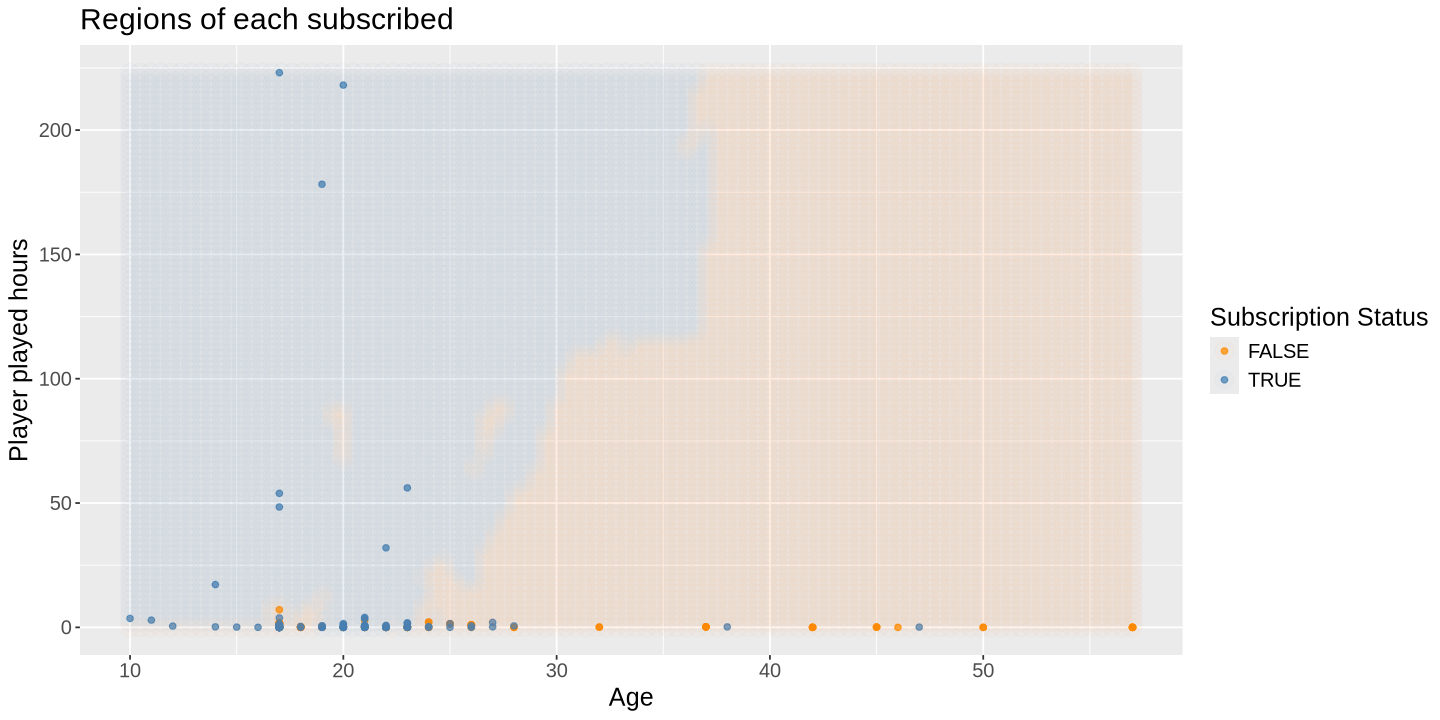

In [14]:
set.seed(1234)
# Final model specification using selected k (21)
final_spec <- nearest_neighbor(weight_func="rectangular", neighbors = 21) |>
    set_engine("kknn") |>
    set_mode("classification")

# Final workflow
final_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(final_spec) |>
    fit(data = upsampled_players)

#Graph with coloured background to check for overfitting/underfitting
age_grid <- seq(min(upsampled_players$age), 
                max(upsampled_players$age), 
                length.out = 100)

hours_grid <- seq(min(upsampled_players$played_hours), 
                max(upsampled_players$played_hours), 
                length.out = 100)

asgrid <- as_tibble(expand.grid(age = age_grid, 
                                played_hours = hours_grid))

knnPredGrid <- predict(final_workflow, asgrid)

prediction_table <- bind_cols(knnPredGrid, asgrid) |>
                    rename(subscribe = .pred_class)


wkflw_plot <- ggplot() + 
                geom_point(data = upsampled_players, 
                mapping = aes(x = age, y = played_hours, color = subscribe), 
                alpha = 0.75) +
                geom_point(data = prediction_table, 
                           mapping = aes(x = age, 
                           y = played_hours, 
                           color = subscribe), 
                           alpha = 0.02, 
                           size = 5) +
                labs(x = "Age", y = "Player played hours", 
                     color = "Subscription Status", 
                     title = "Regions of each subscribed") +
                scale_color_manual(values = c("darkorange", "steelblue")) +
                theme(text = element_text(size = 15))

wkflw_plot
     

#### Figure 14: Regions graphed, showing that the classifier does not underfit nor overfit.

### Accuracy and Confusion Matrix

Evaluate the trained model on the testing set to see the classifier performance on unseen data. We use players_testing to see the accuracy with metrics and its confusion matrix (conf_mat).

In [16]:
set.seed(1234)

# Predict
player_test_predictions <- final_workflow |>
    predict(players_testing) |>
    bind_cols(players_testing)

# Prediction accuracy
player_test_accuracy <- player_test_predictions |> 
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy") 
player_test_accuracy
    
# Confusion matrix to find weak areas of the model 
confusion <- player_test_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)
confusion

.metric  .estimator .estimate
1 accuracy binary     0.3469388

          Truth
Prediction FALSE TRUE
     FALSE     6   25
     TRUE      7   11

#### Figure 15: Confusion Matrix for K-NN Model

Our classifier was 34.69% accurate and labeled 17 out of 49 observations correctly.

## Discussion

### Summary
We found that age and hours played are not effective predictors of newsletter subscription status. In the original model, the model's accuracy was 67.35%, but the classifier predicted TRUE for almost every case due to the strong class imbalance. After applying upsampling to balance the TRUE and FALSE classes, the model’s accuracy dropped to 36.73%, confirming that it could not reliably distinguish between subscribers and non-subscribers. This low accuracy suggests that age and played hours have little to no predictive power for newsletter subscription, and there is likely no strong relationship between these variables and a player’s likelihood of subscribing.

### Expectations

Our findings differed from our initial expectations. We originally anticipated that younger players and those with higher playtime would be more likely to subscribe to the newsletter. However, the results showed that neither age nor hours played were meaningful indicators of subscription status.

Based on an initial review of the data, we expected a strong relationship between these variables and newsletter subscription. Instead, our analysis revealed that using only age and played_hours as predictors was not sufficient for accurate classification. The presence of outliers likely further reduced the model’s performance, making these variables even less reliable.

### Impact

Since age and hours played do not effectively predict newsletter subscription, they should not be used as the primary criteria when identifying player demographics for marketing or outreach.

The UBC research group should consider exploring variables beyond basic demographics and playtime. In-game behaviors such as engagement patterns or feature usage may proove to be more informative about a player’s likelihood of subscribing. Player experience levels could also play a more meaningful role in understanding subscription tendencies.

### Future Questions / Steps

These findings raise new questions about what variables might serve as better predictors of newsletter subscription. For example, factors such as gender, player experience, or specific behavioral metrics could be tested using similar modeling approaches to determine their predictive value.

Additionally, exploring alternative analytical methods such as clustering or more advanced classification techniques may reveal patterns that simple predictive models could not detect. This could help determine whether different methods or additional variables uncover stronger relationships affecting subscription behavior.